# **Testing Flat (n=0.3) Sersic Model Galaxies**
## **128x128 pixel local sky subtraction only** (deepCoadd_calexp)

### 1.) Imports and functions

In [1]:
from lsst.obs.hsc.hscMapper import HscMapper
from lsst.daf.persistence import Butler
import lsst.geom as geom
import lsst.daf.persistence as dafPersist
import lsst.afw.image       as afwImage

import sys
from IPython.display import display, Markdown
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rc,rcParams
from astropy.table import Table
from scipy.special import gamma, gammaincinv

In [2]:
rcParams.update({'font.size':14})

In [3]:
def getRobustCutout(coordinate, size, butler, band, datasetType, tract=9813, tractInfo=None):
    '''
    Courtesy of Markus Dirnberger
    Make cutout at coordinate (regardless of underlying patch layout).    
    Parameters
    ----------
    coordinate : `lsst.geom.SpherePoint`
        A coordinate in LSST format.    
    size : `lsst.geom.Extent2I`
        The cutout size or dimensions.    
    butler : `daf.persistence.Butler`
        Data fetching butler.    
    Returns
    -------
    cutout : `lsst.afwImage.ExposureF`
        The postage stamp cutout, centered at the coordinate.
    '''
    if tractInfo is None:
        skymap    = butler.get('deepCoadd_skyMap', immediate=True)
        tractInfo = skymap[tract]    # get world coordinate system
    wcs = tractInfo.getWcs()
    # calculate desired BBox for the final cutout
    cutoutBBox = geom.Box2I().makeCenteredBox(wcs.skyToPixel(coordinate), size)
    # calculate the BBox of the patch containing the object
    patchInfo = tractInfo.findPatch(coordinate)
    patchBBox = patchInfo.getOuterBBox()
    # get the patch index
    patch = patchInfo.getIndex()    # get an exposure that contains the cutout
    if patchBBox.contains(cutoutBBox):
        # the exposure is simply the patch
        dataId = {'tract': tract, 'filter': band, 'patch': "%d,%d" % patch}
        exposure = butler.get(datasetType, **dataId)
        cutout = exposure.getCutout(coordinate, size)
    else:
        # make a larger exposure that contains the entire cutout BBox
        x, y = patch
        nearbyPatches = (
                         (x-1,y-1), (x-1,y+0), (x-1,y+1), (x+0,y-1),
                         (x,y),
                         (x+0,y+1), (x+1,y-1), (x+1,y+0), (x+1,y+1),
                        )
        overlappingPatches = [
                              n
                              for n in nearbyPatches
                              if cutoutBBox.overlaps(tractInfo.getPatchInfo(n).getOuterBBox())
                             ]        # make a bounding box for the big exposure
        bigBBox = patchBBox
        for o in overlappingPatches:
            bigBBox.include(tractInfo.getPatchInfo(o).getOuterBBox())
        # make the big exposure by assigning subimages
        exposure = afwImage.ExposureF(bigBBox, tractInfo.getWcs())
        for o in overlappingPatches:
            dataId = {'tract': tract, 'filter': band, 'patch': "%d,%d" % o}
            partialExposure = butler.get(datasetType, **dataId)
            # get image data for a section of the big exposure
            subImage = afwImage.ImageF(exposure.getImage(), tractInfo.getPatchInfo(o).getOuterBBox())
            # assign the patch image data
            subImage.assign(partialExposure.getImage())
        cutout = exposure.getCutout(coordinate, size)
            
    return cutout

In [4]:
def find_nearest(arr, val, tol):
    '''
    Finds the first instance of a value close to the provided value in an array.
    Requires:
        - A Numpy array
        - A value to be found
        - The required tolerance (how close to the value is acceptable)
    Returns:
        - The index within the array of the closest value to that provided
    '''
    i = -1
    arr2 = 99
    while (i <= len(arr)) & (arr2 > (val-tol)):
        i += 1
        if arr[i] == 99:
            arr2 = 99
        else:
            arr2 = arr[i]
            
    return i

In [5]:
def mk_ell(imdata, xcen, ycen, pa, ell):    
    '''
    For reprojecting into elliptical coordinates.  Requires:
        1.) Image data array
        2.) Center x coordinate (pixels)
        3.) Center y coordinate (pixels)
        4.) Position angle (degrees)
        5.) Ellipticity (1-b/a)
    Returns a dictionary containing the following:
        1.) xEll, x coordinates in inclined galaxy plane
        2.) yEll, y coordinates in inclined galaxy plane
        3.) ellRad, radius in inclined galaxy plane
        4.) theta, angle in galaxy plane, starting 0 at PA and increasing CCW (radians)

    For example, to plot the deprojected image, do e.g.:
        plt.pcolormesh(xEll, yEll, image)
        plt.imshow(ellRad, origin='lower')
    '''
    dimx = imdata.shape[1]
    dimy = imdata.shape[0]
    if (dimy > dimx):
        x = np.arange(1, dimy+1)
        y = x.reshape(-1, 1)
    else:
        x = np.arange(1, dimx+1)
        y = x.reshape(-1, 1)
    # Currently written to start at PA and increase CCW (due north is 0 degrees)
    xEll = (x - xcen)*np.cos(np.radians(pa+90)) + \
                (y - ycen)*np.sin(np.radians(pa+90))
    yEll = -(x - xcen)*np.sin(np.radians(pa+90)) + \
                 (y - ycen)*np.cos(np.radians(pa+90))

    ellRad = np.sqrt(xEll**2 + (yEll/(1-ell))**2)
    theta = np.arctan2(yEll, xEll)
    theta[theta < 0.] = theta[theta < 0.]+2.0*np.pi # Removing negative values
    
    ellipse = {'xEll': xEll,
               'yEll': yEll,
               'ellRad': ellRad,
               'theta': theta}
    
    return ellipse

In [6]:
def surfbprof(imdata, maskdata, cen, pa, ell, bwidth, maxbin, iflag, magZp=27.0):
    '''
    Quickly does isophotal profiles of galaxy using image sections.  Requires:
        - Image data array
        - Mask data array (0 = not masked, > 0 is masked)
        - Center coordinates (geom.PointI object)
        - Position angle (degrees)
        - Ellipticity (1-axial ratio)
        - Bin width (must be pixels--works off image array)
        - Maximum radius (must be pixels--works off image array)
        - Flag for whether or not to correct for inclination (mu[i]*(1-ell))
            -- 0 = don't correct, != 0 means correct
    Returns a dictionary containing the following:
        - Radius array (in pixels: 'rad')
        - Mean surface brightness within elliptical annuli ('mean_I')
        - Median surface brightness within elliptical annuli ('med_I')
        - The cumulative sum in growing elliptical apertures (or curve of growth: 'cog')
        - Number of pixels within growing elliptical apertures ('npix')
    
    '''
    xcen_i = int(np.round(cen[0], 0)) # Converting to integer value
    ycen_i = int(np.round(cen[1], 0)) # Converting to integer value
    
    if len(np.array([pa]))==1:
        ellipse = mk_ell(imdata, xcen_i, ycen_i, pa, ell)
        ellRad = ellipse['ellRad']
        ellRad = ellRad[ : imdata.shape[0], : imdata.shape[1]]
    
    bins = np.arange(0.5*bwidth, maxbin+0.5*bwidth, bwidth)
    phot_dict = {}
    mean_i = np.zeros(len(bins))-999
    med_i = np.zeros(len(bins))-999
    cog = np.zeros(len(bins))-999
    npix = np.zeros(len(bins))
    for i in range(len(bins)):
        # First shrinking image array to only needed size
        minbin = bins[i]-0.5*bwidth
        maxbin = bins[i]+0.5*bwidth
        offset = int(np.round(maxbin+5)) # how far to grow the image box
        imsec = imdata[ycen_i-offset : ycen_i+offset,
                       xcen_i-offset : xcen_i+offset]
        masksec = maskdata[ycen_i-offset : ycen_i+offset,
                           xcen_i-offset : xcen_i+offset]
        
        if len(np.array([pa]))==1:
            ellRadsec = ellRad[ycen_i-offset : ycen_i+offset,
                               xcen_i-offset : xcen_i+offset]
            want_sb = (ellRadsec >= minbin) & (ellRadsec < maxbin) & (masksec == 0)
            want_cog = (ellRadsec < maxbin) # Currently biases toward overlapping sources
        else:
            ellipse = mk_ell(imsec, offset, offset, pa[i], ell[i])
            ellRad = ellipse['ellRad']
            want_sb = (ellRad >= minbin) & (ellRad < maxbin) & (masksec == 0)
            want_cog = (ellRad < maxbin) # Currently biases toward overlapping sources
            
        # Ignore empty bins
        if len(want_sb[want_sb]) == 0:
            mean_i[i] = -999
            med_i[i] = -999
        else:
            if iflag:
                mean_i[i] = np.nanmean(imsec[want_sb]) * (1-ell)
                med_i[i] = np.nanmedian(imsec[want_sb]) * (1-ell)
            else:
                mean_i[i] = np.nanmean(imsec[want_sb])
                med_i[i] = np.nanmedian(imsec[want_sb])
        cog[i] = np.sum(imsec[want_cog])
        npix[i] = len(imsec[want_cog])
    # Flagging bad values as 99
    cog[cog<=0] = 10**(-0.4*(99-magZp))
    
    phot_dict['rad'] = bins
    phot_dict['mean_I'] = mean_i
    phot_dict['med_I'] = med_i
    phot_dict['cog'] = cog
    phot_dict['npix'] = npix
    
    return phot_dict

In [7]:
def get_mu0(mag, reff, n, magZp=27.0):
    '''
    Calculates the central surface brightness for a given set of Sersic parameters
    Requires:
        - total magnitude
        - effective radius (give in arcsec)
        - Sersic index
        - magnitude zeropoint
    Returns:
        - central surface brightness in mag/arcsec^2
    '''
    def bnn(n, frac):
        return gammaincinv(2*n, frac)
    
    bn = bnn(n, 0.5)
    lTot = 10**(-0.4*(mag-magZp))
    i0 = (lTot*(bn**(2*n)))/(reff**2 * 2*n*np.pi * gamma(2*n))
    mu0 = -2.5*np.log10(i0) + magZp
    
    return mu0

In [8]:
def get_images(inds):
    '''
    Creates a dictionary containing all of the needed imaging data to analyze the fake galaxies
    Requires:
        - index array (just a range() object) to specify which galaxies to process
    Returns:
        - exps, a dictionary containing the deepCoadd and deepCoadd_calexp image cutouts for both
        the data with and without fakes, accessible by photometric band
        
    NOTE: assumes many steps were run previously, e.g. setup of Butlers, arrays containing
    galaxy coordinates, galaxy params table read in, and creation of photometric band list 'bands'
    
    NOTE 2: this takes a very long time to run!
    '''
    exps = {}
    for i in inds:
        print(str(i)+' ', end='', flush=True)
        # Some of the larger Reff models ended up near the edges of the tract, hence the following
        # is necessary to take this into account while still grabbing large enough cutouts
        if (i < 68) & (i > 35):
            bwidth = (reffs[i]/0.168) * 15
        else:
            bwidth = (reffs[i]/0.168) * 10
        cutout_size = geom.ExtentI(bwidth, bwidth)
        pch = patchids[i]
        # Setting up all exposures into the main dictionary, accessible by index and band and type
        exps[str(i)] = {}
        for band in bands:
            exp = getRobustCutout(all_pos[i], cutout_size, butler, band, 'deepCoadd')
        
            exp_fk = getRobustCutout(all_pos[i], cutout_size, butler_fk, band, 'fakes_deepCoadd')
    
            calexp = getRobustCutout(all_pos[i], cutout_size, butler, band, 'deepCoadd_calexp')

            calexp_fk = getRobustCutout(all_pos[i], cutout_size, butler_fk, band, 'fakes_deepCoadd_calexp')
        
            exps[str(i)][band] = {}
            exps[str(i)][band]['exp'] = exp
            exps[str(i)][band]['exp_fk'] = exp_fk
            exps[str(i)][band]['calexp'] = calexp
            exps[str(i)][band]['calexp_fk'] = calexp_fk
            
    return exps

In [9]:
def add_phot_to_dict(inds, exps):
    '''
    Does surface photometry using galaxy images and adds results to the input dictionary
    Requires:
        - an array of indexes, corresponding to the models to be photometered
        - a dictionary of images, constructed using process_galaxies() function
    Returns:
        - nothing, but modifies the input dictionary by adding keys containing surface photometry results
    NOTE: also assumes existence of global variables, including bands array and table with flat model
    parameters.
    '''
    for i in inds:
        for band in bands:
            im_input = exps[str(i)][band]['exp_fk'].image.array - exps[str(i)][band]['exp'].image.array
            im_output = exps[str(i)][band]['calexp_fk'].image.array - exps[str(i)][band]['calexp'].image.array
            msk = im_input*0.0 # Assumes mask array isn't needed for photometry
            cen = (im_input.shape[0]//2, im_input.shape[1]//2)
            pa = flats['pa_bulge'][i]
            ell = 1-flats['b_b'][i]
            p_dict_in = surfbprof(im_input, msk, cen, pa, ell, 2, im_input.shape[0]//2, 0)
            p_dict_out = surfbprof(im_output, msk, cen, pa, ell, 2, im_output.shape[0]//2, 0)
            exps[str(i)][band]['phot_exp'] = p_dict_in
            exps[str(i)][band]['phot_calexp'] = p_dict_out

In [10]:
def get_maxr(inds, exps, band):
    '''
    Derives the array index at which the curve of growth flux is closest to the input catalogue flux.
    Requires:
        - an array of indexes, corresponding to the galaxy models that were photometered
        - a dictionary of galaxy images, output by get_images() and processed with add_phot_to_dict()
        - photometric band to use for the derivation (string)
    Returns:
        - a list containing the indexes at which the flux is closest to the catalogue fluxes for all
        model galaxies selected via inds
    '''
    idxs = []
    for i in inds:
        cog_i = -2.5*np.log10(exps[str(i)][band]['phot_exp']['cog']) + 27.0
        try:
            idx = find_nearest(cog_i, flats['imagVar'][i], 0.1)
        except:
            idx = np.where(cog_i == np.min(cog_i))[0][0]
        idxs.append(idx)
        
    return idxs

In [11]:
def build_full_catalogue(inds, exps, idxs):
    '''
    Creates a new dictionary containing the values of the curves of growth at the maximum radii derived via
    get_maxr() for each model galaxy and photometric band.
    Also then adds in the input model central surface brightness (derived using get_mu0()) and effective
    radius (catalogue value)
    Requires:
        - array of indexes corresponding to the model galaxies being processed
        - dictionary produced by get_images() then processed by add_phot_to_dict()
        - list of indexes specifying where the curves of growth for each model reach the closest to the
        input catalogue value (output of get_maxr())
    Returns:
        - dictionary of photometric parameters for all model galaxies in all bands.  Key structure is: 
        band+param, where band = photometric band string (e.g. 'HSC-I') and param is the name of the 
        parameter.
            _exp: total magnitude from input model
            _calexp: total magnitude from deepCoadd_calexp model
            _input: catalogue magnitude
            _mu0: catalogue central surface brightness
            _reff: catalogue effective radius
            
    NOTE: as other functions, assumes existence of input catalogue table and list of photometric bands.
    '''
    cog_mags = {}
    for band in bands:
        bnd = band[-1].lower()+'magVar'
        cog_mags[band+'_exp'] = np.zeros(len(inds))-999
        cog_mags[band+'_calexp'] = np.zeros(len(inds))-999
        cog_mags[band+'_input'] = np.zeros(len(inds))-999
        cog_mags[band+'_mu0'] = np.zeros(len(inds))-999
        cog_mags[band+'_reff'] = np.zeros(len(inds))-999
        for j in range(len(inds)):
            cog_exp = -2.5*np.log10(exps[str(inds[j])][band]['phot_exp']['cog']) + 27.0
            cog_calexp = -2.5*np.log10(exps[str(inds[j])][band]['phot_calexp']['cog']) + 27.0
            # If no valid maximum radius was found, use the highest point in the curve
            if cog_exp[idxs[j]] == 99:
                cog_mags[band+'_exp'][j] = np.min(cog_exp)
            else:
                cog_mags[band+'_exp'][j] = cog_exp[idxs[j]]
            if cog_calexp[idxs[j]] == 99:
                cog_mags[band+'_calexp'][j] = np.min(cog_calexp)
            else:
                cog_mags[band+'_calexp'][j] = cog_calexp[idxs[j]]
            cog_mags[band+'_input'][j] = flats[bnd][inds[j]]
            mu0_new = get_mu0(flats[bnd][inds[j]], 
                              flats['BulgeHalfLightRadius'][inds[j]], 
                              flats['bulge_n'][inds[j]])
            cog_mags[band+'_mu0'][j] = mu0_new
            cog_mags[band+'_reff'][j] = flats['BulgeHalfLightRadius'][inds[j]]
            
    return cog_mags

In [12]:
def plot_all_bands(cog_mags, var):
    '''
    Makes a plot demonstrating the difference between the magnitudes derived from the input models vs.
    those derived from the sky-subtracted model vs. the input catalogue magnitudes.
    Requires:
        - dictionary of photometric quantities derived from build_full_catalogue()
        - name of variable you want to plot (string).  Options are either 'mu0' or 'reff'
    Returns:
        Nothing
    '''
    fig, ax = plt.subplots(2, 3, figsize=(18, 12))
    ms = 15
    for j in range(len(bands)):
        diff_exp = cog_mags[bands[j]+'_exp'] - cog_mags[bands[j]+'_input']
        diff_calexp = cog_mags[bands[j]+'_calexp'] - cog_mags[bands[j]+'_input']
        if j<3:
            ax[0,j].plot(cog_mags[bands[j]+'_'+var], diff_exp, 'k.', label='deepCoadd', markersize=ms)
            ax[0,j].plot(cog_mags[bands[j]+'_'+var], diff_calexp, 'g^', label='deepCoadd_calexp', markersize=ms)
            ax[0,j].axhline(0.0, c='r', linestyle=':')
            ax[0,j].legend()
            ax[0,j].set_title(bands[j])
            ax[0,j].set_ylim([-0.5, 2])
            ax[0,j].set_ylabel(r'$\Delta m_{\lambda}$')
            if var=='mu0':
                ax[0,j].set_xlabel(r'Input $\mu_{0, \lambda}$')
            elif var=='reff':
                ax[0,j].set_xlabel(r'Input R$_{eff}$ (arcsec)')
        else:
            ax[1,j-3].plot(cog_mags[bands[j]+'_'+var], diff_exp, 'k.', label='deepCoadd', markersize=ms)
            ax[1,j-3].plot(cog_mags[bands[j]+'_'+var], diff_calexp, 'g^', label='deepCoadd_calexp', markersize=ms)
            ax[1,j-3].axhline(0.0, c='r', linestyle=':')
            ax[1,j-3].legend()
            ax[1,j-3].set_title(bands[j])
            ax[1,j-3].set_ylim([-0.5, 2])
            ax[1,j-3].set_ylabel(r'$\Delta m_{\lambda}$')
            if var=='mu0':
                ax[1,j-3].set_xlabel(r'Input $\mu_{0, \lambda}$')
            elif var=='reff':
                ax[1,j-3].set_xlabel(r'Input R$_{eff}$ (arcsec)')
    ax[1,2].axis('off')
    plt.tight_layout()

### 2.) Setting up Butlers

In [13]:
# Universal values for importing data
bands = ['HSC-G', 'HSC-R', 'HSC-I', 'HSC-Z', 'HSC-Y']
tract = 9813 # HSC COSMOS

In [14]:
# Imaging without fake injections
repo = '/datasets/hsc/repo/rerun/RC/w_2020_26/DM-25714'
butler = Butler(repo)

# Imaging with fakes injected
fksrepo = '/home/lskelvin/fakes_lsstuk/output/flat_models'
butler_fk = Butler(fksrepo)

NOTE: due to continual testing, the directory structure given above may not be stable over time.  If the directory is no longer accessible, contact Lee Kelvin.

### Reading in model galaxy parameters from input table

In [15]:
flats = Table.read('/home/lskelvin/fakes_lsstuk/input/flat_models.fits') # Directory here also subject to change

ra = flats['raJ2000']
dec = flats['decJ2000']
reffs = flats['BulgeHalfLightRadius']
iMags = flats['imagVar']
ns = flats['bulge_n']
iMu0 = get_mu0(iMags, reffs, ns)

### Finally, getting the patch IDs for all necessary patches in tract 9813

In [16]:
skymap = butler.get("deepCoadd_skyMap")
tractInfo = skymap[tract]
wcs = tractInfo.getWcs()
patchids = []
all_pos = []
for i in range(len(ra)):
    pos = geom.SpherePoint(ra[i], dec[i], geom.radians)
    all_pos.append(pos) # Coordinates of all galaxies, as SpherePoint objects
    patchInfo = tractInfo.findPatch(pos)
    patch = patchInfo.getIndex()
    patchids.append(str(patch[0])+','+str(patch[1])) # All patches for all galaxies

# **Analyzing the results**

Here we explain the methodology behind measuring model magnitudes.

---

To begin, the reason we set up Butlers for the unmodified HSC dataset (without models) and the dataset with model injections separately is so that we can isolate the model galaxies from the astrophysical background.  If one subtracts the image with the model in it (accessed by the Butler as `fakes_*`; see `get_images()` above) from the image without the model, it leaves behind only the model.

We can further take advantage of this to isolate the individual data processing steps we are testing.  In this case, we are testing the very last round of sky subtraction, which is done using a small (128x128 pixel) mesh to remove all of the LSB residuals that bridge galaxies in the real sky.  This is needed to optimize the deblender for weak-lensing science.  

This specific sky subtraction is implemented at the `deepCoadd_calexp` stage.  Therefore, subtracting the `deepCoadd_calexp` images from the `deepCoadd` images yields the final sky subtraction.  Similarly, in our case, subtracting the `deepCoadd` images from the `fakes_deepCoadd_calexp` images yields the sky-subtracted models, as these models were injected at the `deepCoadd` stage.  We can then compare these sky-subtracted models to the input models, the latter being accessible by subtracting the `deepCoadd` images from the `fakes_deepCoadd` images.

---

To actually measure the magnitudes, we want full control so we measure them directly from the images of the models, built as described above.  To keep things simple, and because by subtracting off the astrophysical background we are left with negligible noise, we simply measure aperture magnitudes.

To do this, we first derive the radius at which most of the flux is captured using the input models' curves of growth (see `surfbprof()` above).  To keep this simple, we derive this radius only from the i-band, then use the same radius to measure every model's total magnitude (the viability of this is verified by the small deviations we find between aperture magnitudes and input catalogue magnitudes in all bands; see results below).  We then compare the aperture magnitudes we measure from the sky-subtracted models against those we derive from the unmodified models, which tells us how much the total flux is being oversubtracted by the algorithm.

---

Accessing the model information happens as follows.  The model galaxies were created in grids of 6x6 galaxies.  Therefore, their order in the input table is set by the schema in which they were created:

1. Constant surface brightness, constant separation, varying size (6x6 galaxies)

2. Constant size, constant separation, varying surface brightness (6x6 galaxies)

3. Constant size, constant surface brightness, varying separation (6x12 galaxies, or 6x6 pairs)

Therefore, the galaxies are accessible by index in the following manner:

1. Indexes 0--35 are case 1 above

2. Indexes 36--71 are case 2 above

3. Index 72--end are case 3 above

We will treat the final case (3) in a separate notebook due to the different method required to measure fluxes of overlapping galaxies.

## **Effect with varying surface brightness, constant size & spacing**

In [17]:
# Starting with surface brightness, so first 36 indexes.
sb_inds = range(36)
sb_exps = get_images(sb_inds)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 

### Example model galaxy, pre- and post-sky subtraction

Text(0.5, 1.0, 'Post Sky-subtraction')

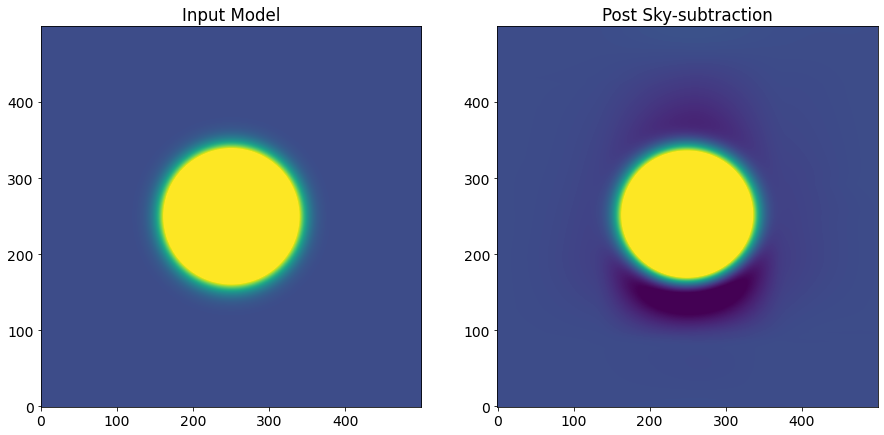

In [19]:
fig, ax = plt.subplots(1,2, figsize=(15,10))
bnd = 'HSC-I'
i = 21
ax[1].imshow(sb_exps[str(i)][bnd]['calexp_fk'].image.array-sb_exps[str(i)][bnd]['calexp'].image.array, 
             origin='lower', vmin=-0.03, vmax=0.1)
ax[0].imshow(sb_exps[str(i)][bnd]['exp_fk'].image.array-sb_exps[str(i)][bnd]['exp'].image.array, 
             origin='lower', vmin=-0.03, vmax=0.1)
ax[0].set_title(r'Input Model')
ax[1].set_title(r'Post Sky-subtraction')

In [20]:
# Now doing surface photometry
add_phot_to_dict(sb_inds, sb_exps)

In [21]:
# Now deriving the radii at which the curves of growth reach the input catalogue magnitudes
sb_idxs = get_maxr(sb_inds, sb_exps, 'HSC-I')

In [22]:
# Creating dictionary of total magnitudes and catalogue photometric parameters
sb_cog_mags = build_full_catalogue(sb_inds, sb_exps, sb_idxs)

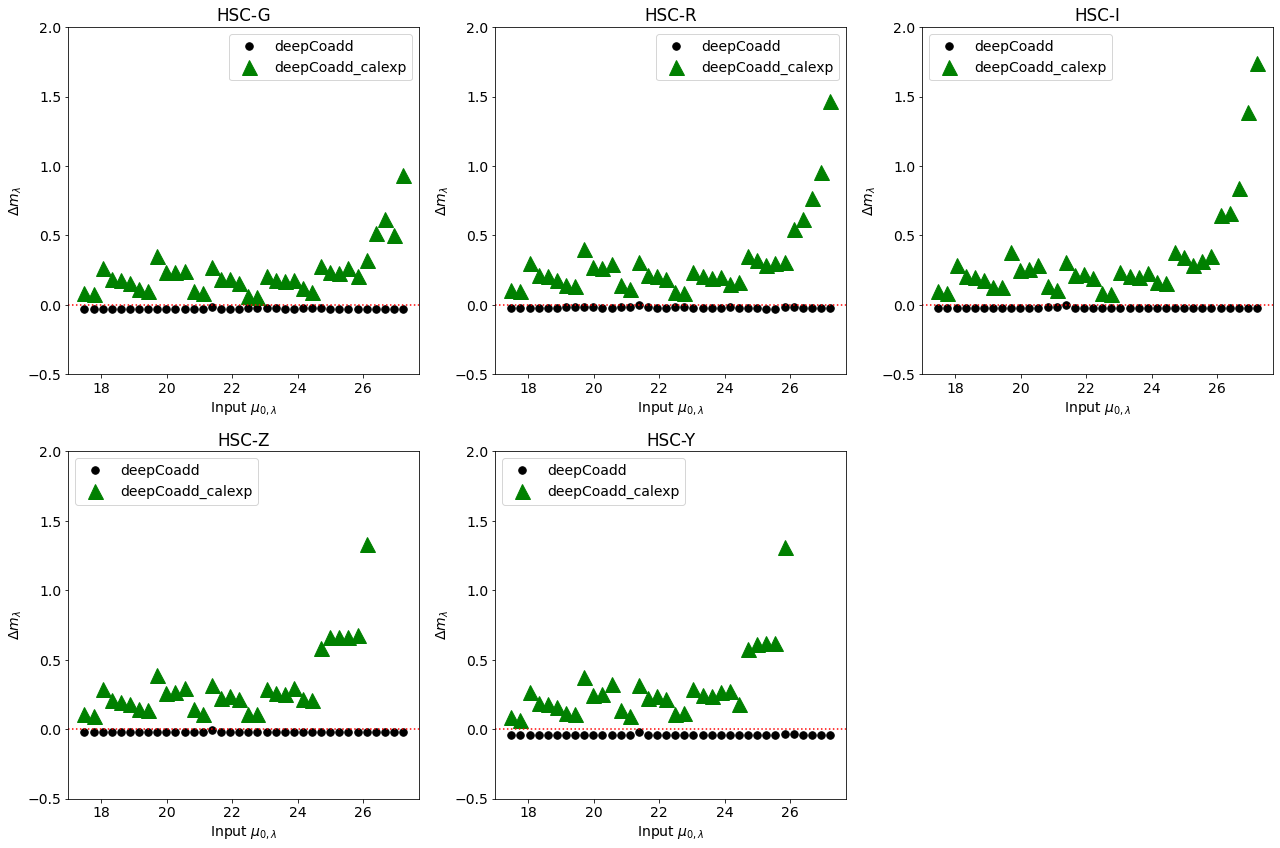

In [23]:
plot_all_bands(sb_cog_mags, 'mu0')

Over-subtraction in the above plots are indicated by positive values on the y-axis.  A value of zero means no difference from the input catalogue values.  There appears to be some systematic overestimate of the fluxes in the input models, possibly due to low-level differences between the `deepCoadd` databases with and without the models, however these differences are negligible.  There is over-subtraction present in all `deepCoadd_calexp` models, however, with worse over-subtraction for lower surface brightness objects.

All models in this array are roughly 8" in effective radius (50 pixels), almost 1/2 the mesh size.  Presumably this is why all models are being oversubtracted to some degree.  We explore this more in the next section.  The over-subtraction is substantially worse for lower surface brightness objects, with mu0 roughly 25--26 the typical cutoff value (depending on the photometric band).  The lowest surface brightness galaxies are seeing oversubtractions of > 1.5 magnitudes (meaning their flux is underestimated by a factor of about 4).

## **Effect with varying size, constant surface brightness and spacing**

In [24]:
re_inds = np.arange(36, 72)
re_exps = get_images(re_inds)

36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 

In [25]:
# Now doing surface photometry
add_phot_to_dict(re_inds, re_exps)

In [26]:
# Now deriving the radii at which the curves of growth reach the input catalogue magnitudes
re_idxs = get_maxr(re_inds, re_exps, 'HSC-I')

In [27]:
# Creating dictionary of total magnitudes and catalogue photometric parameters
re_cog_mags = build_full_catalogue(re_inds, re_exps, re_idxs)

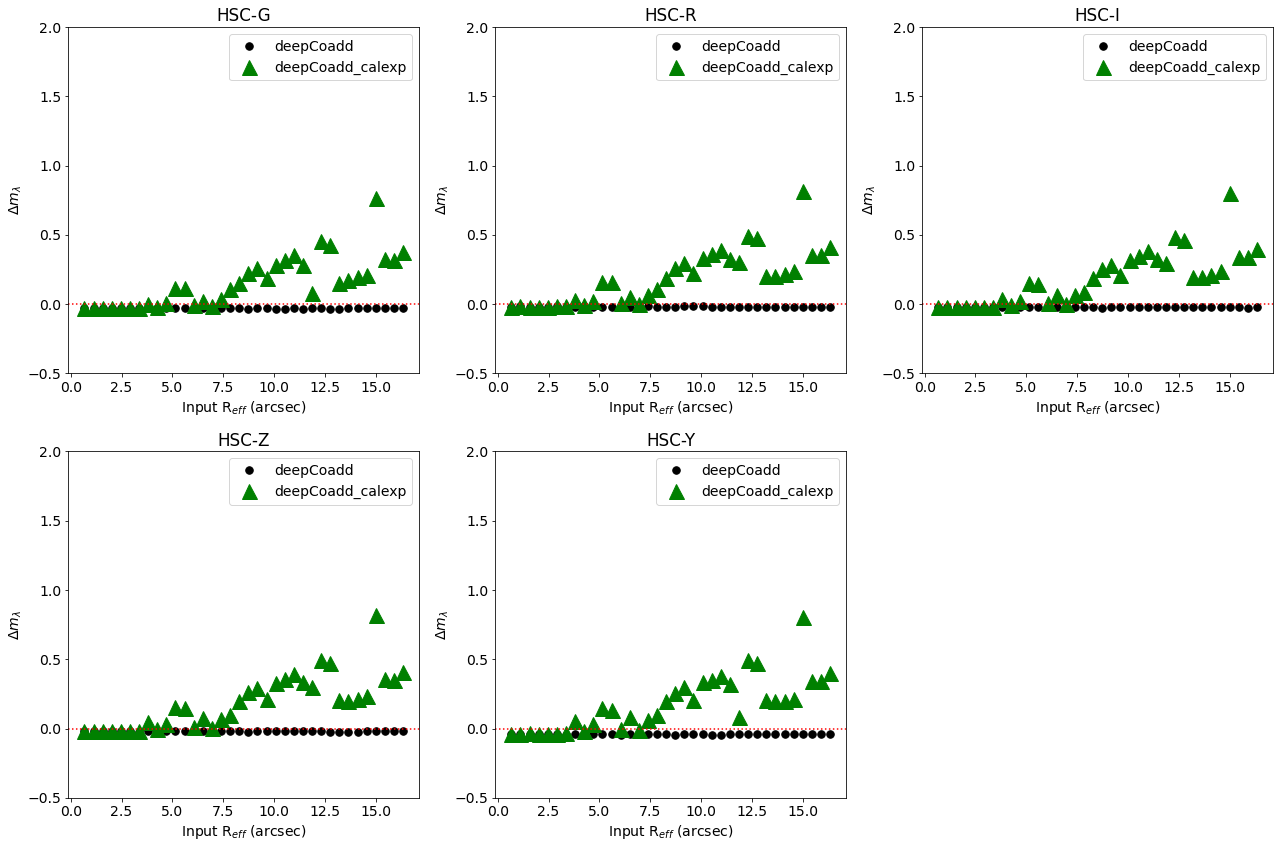

In [28]:
plot_all_bands(re_cog_mags, 'reff')

A similar trend is appearing here as appeared with the surface brightness experiment.  In this case, albeit with some exceptions, the larger the model the worse the over-subtraction, with prominent over-subtraction beginning for galaxies with sizes of approximately 7.5" (45px) Reff.  This is expected if the mesh-based approach is the culprit, as objects with sizes approximately on the order of the mesh size will always be severely over-subtracted--there will be no true sky pixels in the meshes containing the object, so the object itself becomes the sky that is subtracted.

## **Interpretation**

We have thus uncovered the following trends: lower surface brightness objects are more badly over-subtracted than higher-surface brightness objects, and larger objects are more badly over-subtracted than small objects.

The behavior isn't strictly linear, however.  We can try to understand why by plotting the images of each galaxy as they appear in the data, to see if any foreground objects are causing additional under- or over-subtraction in the models, or if something else is the root of the variability.  We do this below using the G-band images of the varying Reff models, which show a large amount of variation atop the general trends at large size.

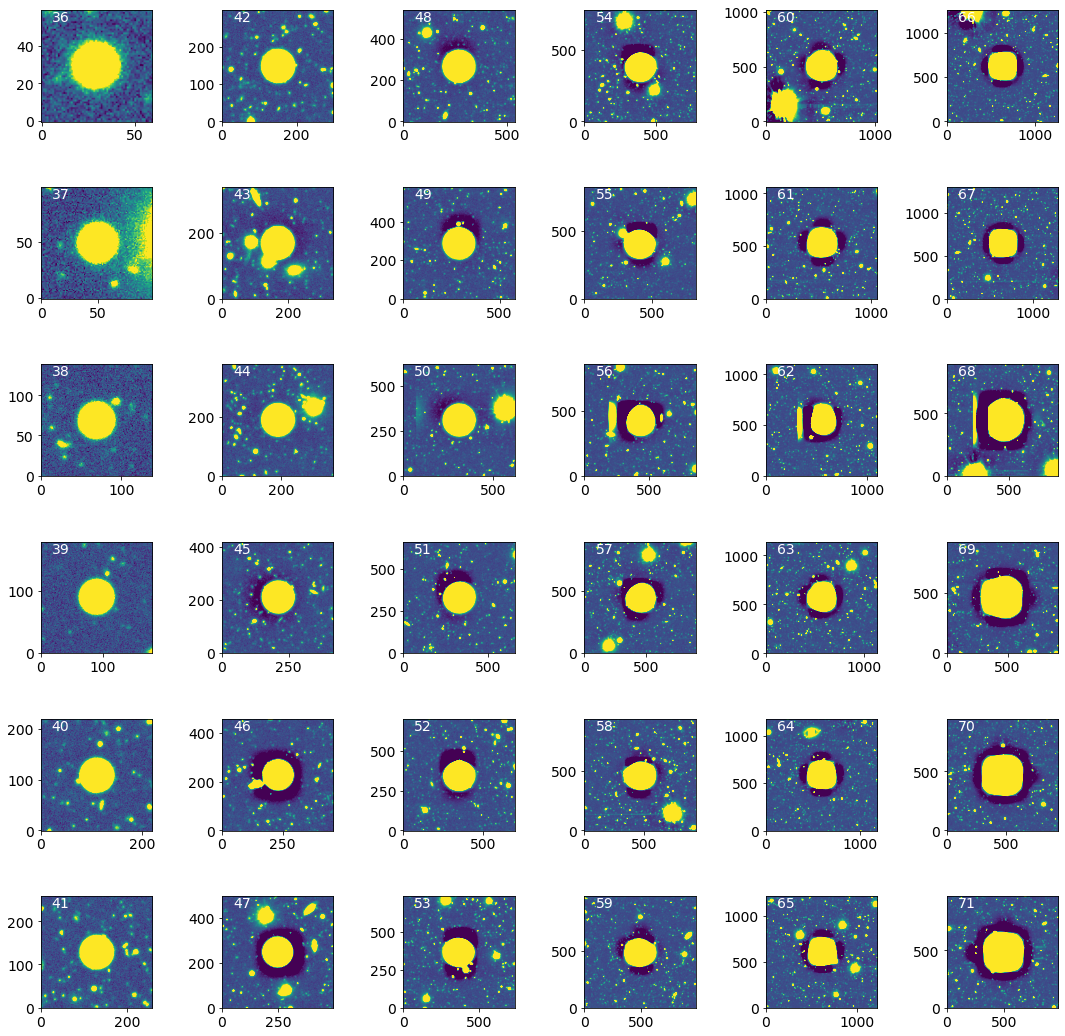

In [29]:
fig, ax = plt.subplots(6, 6, figsize=(15, 15))
for i in range(6):
    for j in range(6):
        ind = 36 + i + 6*j
        ax[i,j].imshow(re_exps[str(ind)]['HSC-G']['calexp_fk'].image.array, 
                       origin='lower', 
                       vmin=-0.03, 
                       vmax=0.1)
        ax[i,j].annotate(str(ind), xy=(0.1, 0.9), xycoords='axes fraction', c='w')
plt.tight_layout()

Two large outliers from the overall trends shown above are galaxies 61 (not badly over-subtracted compared to neighbors) and 68 (very badly over-subtracted compared to neighbors).  The indexes of each galaxy are shown in the upper left of the above cutouts (please note the pixel scales; these galaxies are not the same size).  Galaxy 61 shows a kind of cross pattern, while galaxy 68 shows more of a box centered on the model.  If the mesh is the culprit here, the cross pattern might suggest this galaxy landed at the corners of several different boxes in the mesh (hence it was over-subtracted only piecemeal), while the box might suggest the galaxy landed in the center of the mesh (hence it became the sky within that particular box in the mesh).  Evidence for the latter comes from galaxies 46 and 47, which one can see are also over-subtracted compared to their neighbors, despite their small model sizes, and both of which show similar box patterns in their over-subtraction.

Presence or absence of neighboring objects in the sky likely thus has some impact, but it seems the biggest impact arises due to where the model happened to be placed in relation to the grid used to model the sky, under this assumption.

---

The effect of size thus appears to be rather important, given how sensitive it is to the choice of mesh used to estimate the sky.  Below we demonstrate this further, using the smallest model and the largest model, by showing their surface brightness profiles before and after sky-subtraction.

In [30]:
rd_big = re_exps['71']['HSC-I']['phot_calexp']['rad']
medi_big = re_exps['71']['HSC-I']['phot_calexp']['med_I']
mu_big_calexp = -2.5*np.log10(medi_big) + 27 + 2.5*np.log10(0.168**2)

medi_big = re_exps['71']['HSC-I']['phot_exp']['med_I']
mu_big_exp = -2.5*np.log10(medi_big) + 27 + 2.5*np.log10(0.168**2)

/opt/lsst/software/stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()
/opt/lsst/software/stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log10


In [31]:
rd_small = re_exps['36']['HSC-I']['phot_calexp']['rad']
medi_small = re_exps['36']['HSC-I']['phot_calexp']['med_I']
mu_small_calexp = -2.5*np.log10(medi_small) + 27 + 2.5*np.log10(0.168**2)

medi_small = re_exps['36']['HSC-I']['phot_exp']['med_I']
mu_small_exp = -2.5*np.log10(medi_small) + 27 + 2.5*np.log10(0.168**2)

/opt/lsst/software/stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()
/opt/lsst/software/stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log10


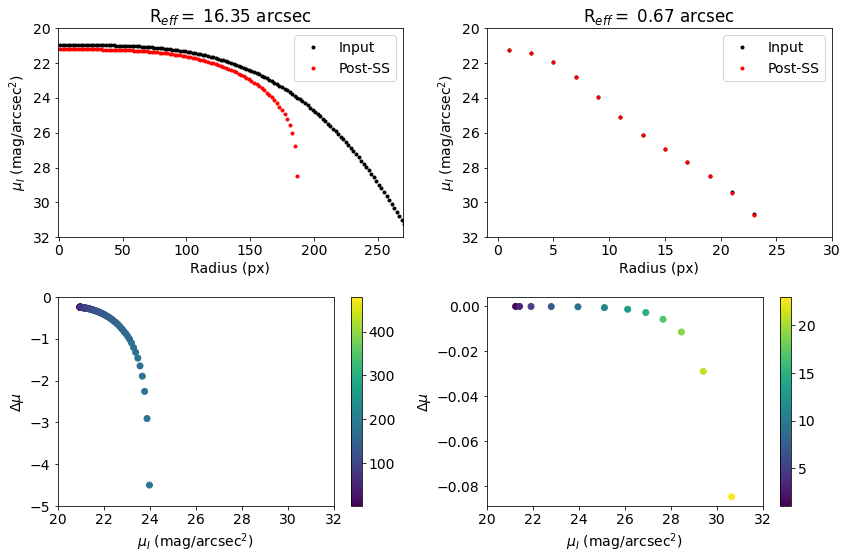

In [34]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# Left plots; large galaxy
ax[0,0].plot(rd_big, mu_big_exp, 'k.', label='Input')
ax[0,0].plot(rd_big, mu_big_calexp, 'r.', label='Post-SS')
ax[0,0].set_xlim([-1, 270])
ax[0,0].set_ylim([32, 20])
ax[0,0].set_xlabel('Radius (px)')
ax[0,0].set_ylabel(r'$\mu_{I}$ (mag/arcsec$^{2}$)')
ax[0,0].legend()
ax[0,0].set_title('R$_{eff} =$ %.2f arcsec'%(re_cog_mags['HSC-I_reff'][-1]))

im1 = ax[1,0].scatter(mu_big_exp, mu_big_exp-mu_big_calexp, marker='o', c=rd_big)
ax[1,0].set_xlim([20, 32])
ax[1,0].set_ylim([-5, 0])
fig.colorbar(im1, ax=ax[1,0])
ax[1,0].set_xlabel(r'$\mu_{I}$ (mag/arcsec$^{2}$)')
ax[1,0].set_ylabel(r'$\Delta \mu$')

# Right plots
ax[0,1].plot(rd_small, mu_small_exp, 'k.', label='Input')
ax[0,1].plot(rd_small, mu_small_calexp, 'r.', label='Post-SS')
ax[0,1].set_xlim([-1, 30])
ax[0,1].set_ylim([32, 20])
ax[0,1].set_xlabel('Radius (px)')
ax[0,1].set_ylabel(r'$\mu_{I}$ (mag/arcsec$^{2}$)')
ax[0,1].legend()
ax[0,1].set_title('R$_{eff} =$ %.2f arcsec'%(re_cog_mags['HSC-I_reff'][0]))

im2 = ax[1,1].scatter(mu_small_exp, mu_small_exp-mu_small_calexp, marker='o', c=rd_small)
ax[1,1].set_xlim([20, 32])
fig.colorbar(im2, ax=ax[1,1])
ax[1,1].set_xlabel(r'$\mu_{I}$ (mag/arcsec$^{2}$)')
ax[1,1].set_ylabel(r'$\Delta \mu$')

plt.tight_layout()

The left panels show the I-band surface brightness profiles (top) of the largest Reff model, pre- (black) and post-sky subtraction (red), and the difference between the two (black - red, with points color-coded by radius; bottom).  The right panels show the same but for the smallest Reff model.

Both models have the same, fairly standard central surface brightness (mu0 = 21, typical for disk galaxies).  The larger galaxy is over-subtracted at all radii, however, where the smaller galaxy is only very slightly over-subtracted at its edge (not even 0.1 mag difference).  The larger galaxy, by its outskirts, is over-subtracted by > 5 magnitudes. Size appears to be the dominant factor regarding this over-subtraction, again pointing to the mesh-based sky estimation approach as the culprit behind this effect.

Weak-lensing scientists and high-redshift scientists will not have to worry about significant flux loss due to this sky subtraction approach.  All other galaxies scientists, however, will.

## **Conclusions**

Subtracting sky by modeling it with a very small mesh size evidently does nothing good for astrophysics involving objects of low surface brightness and/or large angular size.  If this is the requirement for weak-lensing science, then the final weak-lensing data-products will simply be unusable for the rest of the community.  A bifurcation in the data reduction pipeline may be needed to preserve galaxies and LSB science in LSST.